In [1]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) 

In [70]:
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Nadam, Adam, SGD
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.utils import plot_model
from keras.callbacks import Callback
#from sklearn.model_selection import train_test_split,
#KFold, GridSearchCV
#from sklearn.metrics import confusion_matrix, 
#classification_report, accuracy_score
from keras.wrappers import scikit_learn
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
#from keras.utils import model_to_dot
#from keras_contrib.losses import jaccard
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpeg'
seed = 2000

In [43]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
   

In [15]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [16]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [17]:
# Initializing all the images into 4d arrays.

filelist_trainx = sorted(glob.glob('trainx/*.jpg'), key=numericalSort)
#filelist_trainx.sort()
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('trainy/*.jpg'), key=numericalSort)
#filelist_trainy.sort()
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = sorted(glob.glob('testx/*.jpg'), key=numericalSort)
#filelist_testx.sort()
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = sorted(glob.glob('testy/*.jpg'), key=numericalSort)
#filelist_testy.sort()
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

filelist_valx = sorted(glob.glob('validationx/*.jpg'), key=numericalSort)
#filelist_valx.sort()
X_val = np.array([np.array(Image.open(fname)) for fname in filelist_valx])

filelist_valy = sorted(glob.glob('validationy/*.jpg'), key=numericalSort)
#filelist_valy.sort()
Y_val = np.array([np.array(Image.open(fname)) for fname in filelist_valy])

y = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


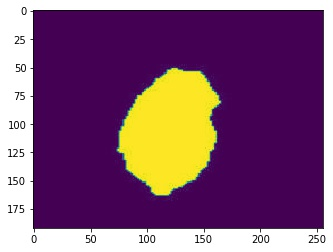

In [18]:
index = 100
plt.imshow(Y_val[index])
print ("y = " + str(np.squeeze(Y_val[:, index])))

In [19]:
def UnPooling2x2ZeroFilled(x):
    
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)

    sh = x.get_shape().as_list()
    if None not in sh[1:]:
        out_size = [-1, sh[1] * 2, sh[2] * 2, sh[3]]
        return tf.reshape(out, out_size)
    else:
        shv = tf.shape(x)
        ret = tf.reshape(out, tf.stack([-1, shv[1] * 2, shv[2] * 2, sh[3]]))
        return ret

In [9]:
# Pipe Line

(x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

def model_seg():
  
  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  
  hist = model.fit(x_train, y_train, epochs= 1, batch_size= 16,validation_data=(x_test, y_test), verbose=1)
  
  model.save("model.h5")
  
  accuracy = model.evaluate(x=x_test,y=y_test,batch_size=16)
  print("Accuracy: ",accuracy[1])

In [10]:
model_seg()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 600 samples
Epoch 1/1
600/600 [==============================] - 552s 919ms/step
Accuracy:  0.2910840825239817


In [11]:
  (x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)
  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  model.load_weights("model.h5")
  predictions_valid = model.predict(x_val, batch_size=16, verbose=1)
  accuracy = model.evaluate(x=x_val,y=y_val,batch_size=16)
  print("Accuracy: ",accuracy[1])

150/150 [==============================] - 168s 1s/step
Accuracy:  0.36829888383547466


In [87]:
 def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
   
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) 
                   + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(history)

NameError: name 'history' is not defined

In [73]:
index = 45
predict_input = x_val[index]
ground_truth = y_val[index]

NameError: name 'x_val' is not defined

In [41]:
predictions =model.predict(predict_input.reshape(1,192,256,3), batch_size=1)
prediction = predictions.reshape(192, 256)

NameError: name 'model' is not defined

In [40]:
#index = 45
plt.figure()
plt.imshow(prediction)
plt.title('Predicted')
plt.figure()
plt.imshow(ground_truth)
plt.title('Ground Truth')

NameError: name 'prediction' is not defined

<Figure size 432x288 with 0 Axes>